In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from seqprop.visualization import *
from seqprop.generator import *
from seqprop.predictor import *
from seqprop.optimizer import *

from definitions.aparent_legacy_without_padding_with_dense import load_saved_predictor


Using TensorFlow backend.


<h2>Define Cleavage Loss Function and SeqProp Wrapper</h2>

- Define a cleavage loss function generator, maximizing cuts at the target position.<br/>
- Build a SeqProp wrapper that builds the generator and predictor, and executs the optimization.<br/>


In [2]:

#Define target cleavage loss function
def get_cleavage_loss(cut_pos, use_start=0, use_end=70, use_target_bits=1.8, cse_start=70, cse_end=76, cse_target_bits=1.8, dse_start=76, dse_end=125, dse_target_bits=1.8, entropy_weight=0.0, punish_up_c=0.0, reward_dn_ggcc=0.0, punish_up_aa=0.0, punish_dn_aa=0.0) :
    
    target_cuts = np.zeros((1, 1, 186))
    target_cuts[:, :, cut_pos] = 1.0
    
    use_entropy_mse = get_target_entropy_sme(pwm_start=use_start, pwm_end=use_end, target_bits=use_target_bits)
    cse_entropy_mse = get_target_entropy_sme(pwm_start=cse_start, pwm_end=cse_end, target_bits=cse_target_bits)
    dse_entropy_mse = get_target_entropy_sme(pwm_start=dse_start, pwm_end=dse_end, target_bits=dse_target_bits)
    
    punish_up_c_func = get_punish_c(pwm_start=0, pwm_end=49)
    
    
    punish_dn_gg_func = get_punish_gg(pwm_start=60, pwm_end=90)
    punish_dn_cc_func = get_punish_cc(pwm_start=60, pwm_end=90)
    
    punish_up_aa_func = get_punish_aa(pwm_start=0, pwm_end=49)
    punish_dn_aa_func = get_punish_aa(pwm_start=55, pwm_end=100)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred, dense_out = predictor_outputs

        #Create target cut constant
        cut_true = K.tile(K.constant(target_cuts), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, cut_pred), axis=0)
        
        seq_loss = 0.0
        seq_loss += punish_up_c * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        
        seq_loss += reward_dn_ggcc * (-1.) * K.mean(punish_dn_gg_func(pwm) * punish_dn_cc_func(pwm), axis=0)
        
        seq_loss += punish_up_aa * K.mean(punish_up_aa_func(sampled_pwm), axis=0)
        seq_loss += punish_dn_aa * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        #entropy_loss = entropy_weight * target_entropy_mse(pwm) + 0.5 * cse_entropy_mse(pwm)
        entropy_loss = entropy_weight * (use_entropy_mse(pwm) + cse_entropy_mse(pwm) + dse_entropy_mse(pwm))
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, target_cuts, loss_funcs, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        target_cut = target_cuts[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=185, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context=22), n_sequences=n_sequences, n_samples=n_samples, eval_mode='pwm')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, cse_start_pos=49, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=49-40, pwm_end=55+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts
        


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models/legacy_models')
model_name = 'aparent_theano_legacy_30_31_34.h5'
model_path = os.path.join(save_dir, model_name)

<h2>Define the Sequence Template and Target Cuts</h2>

- Hard-code the Alien1 UTR context into the sequence to optimize..<br/>
- Make a list of target cut positions to maximize.<br/>


In [4]:
#Define standard sequence template

seq_template = 'ATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTGT'

#Define list of target cleavage positions

cut_objectives = [60, 65, 70, 75, 80, 85, 90, 95, 100]


<h2>Run SeqProp to Maximize Cleavage (Standard objective)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Auxiliary objectives: Punish upstream C, reward packing Gs and Cs in stretches.<br/>


Running optimization experiment 'Vanilla'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/1
2000/2000 [==============================] - 83s 41ms/step - loss: 1.6629


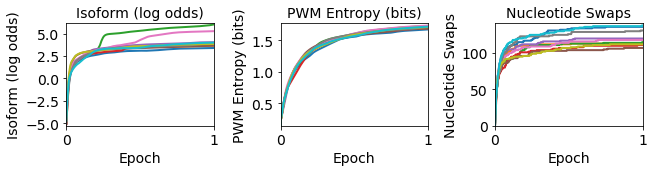

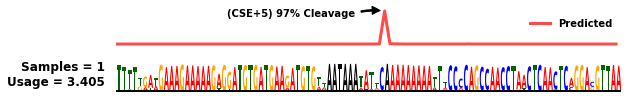

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 67s 33ms/step - loss: 1.1362


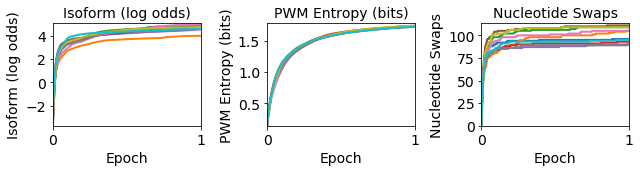

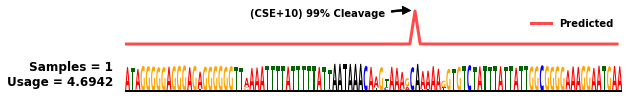

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 83s 42ms/step - loss: 0.9424


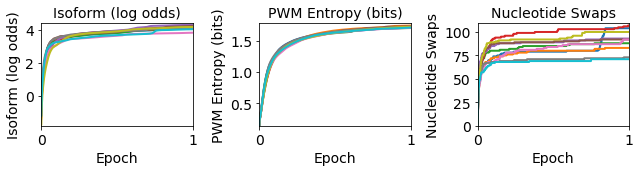

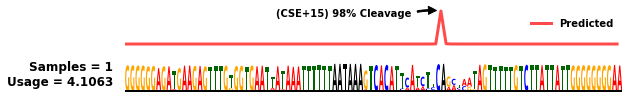

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 83s 42ms/step - loss: 1.0672


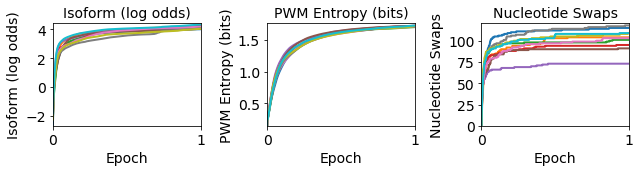

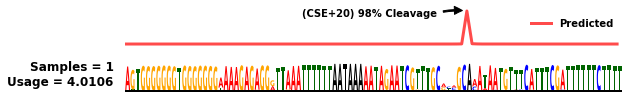

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 85s 43ms/step - loss: 1.0927


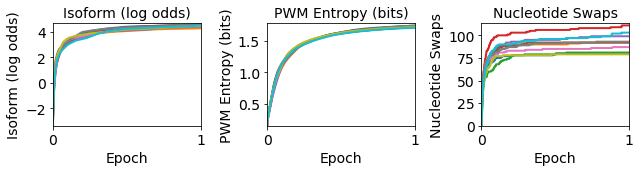

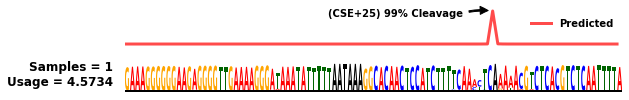

Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 82s 41ms/step - loss: -2.2600


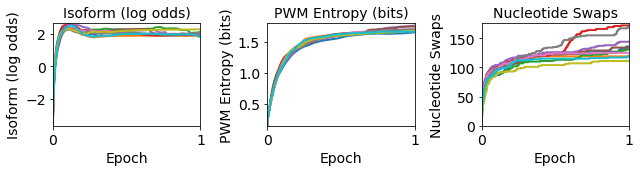

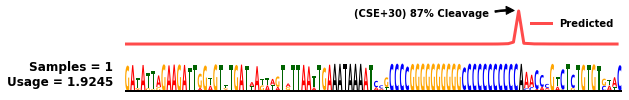

Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 86s 43ms/step - loss: 0.1612


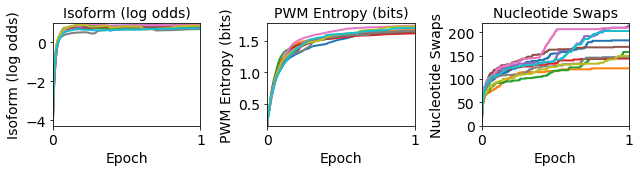

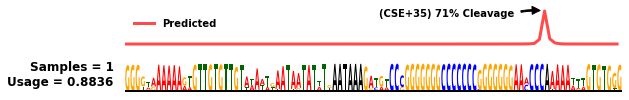

Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 74s 37ms/step - loss: 0.2096


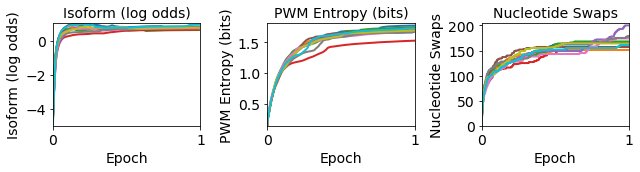

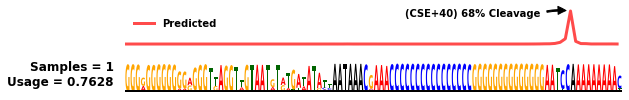

Optimizing objective 8...
Epoch 1/1
2000/2000 [==============================] - 82s 41ms/step - loss: 1.8525


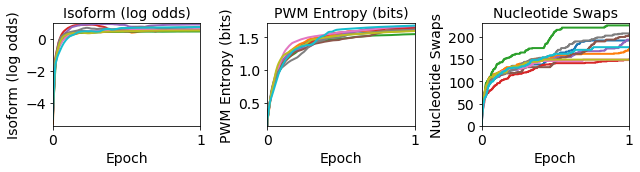

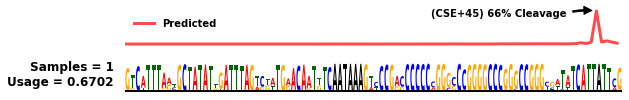

In [5]:
#Run SeqProp Optimization (experiment 'Vanilla')

print("Running optimization experiment 'Vanilla'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.005,
        reward_dn_ggcc=0.005 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.0,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

vanilla_pwms, vanilla_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


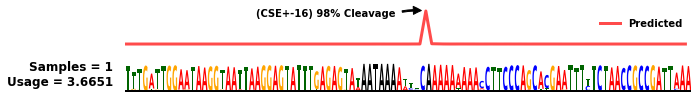

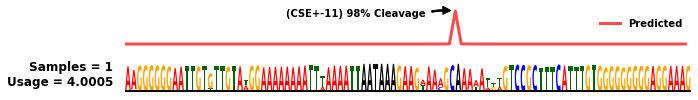

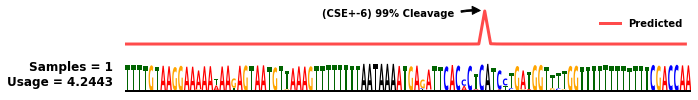

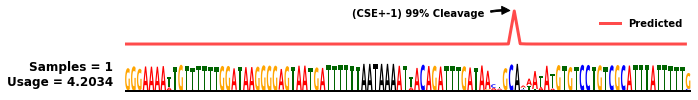

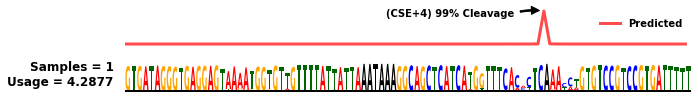

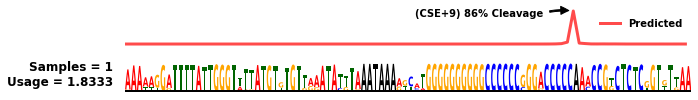

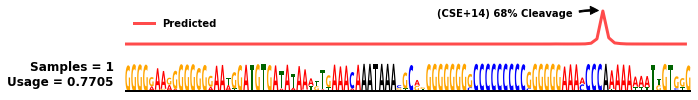

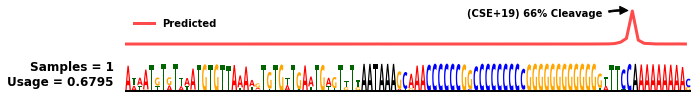

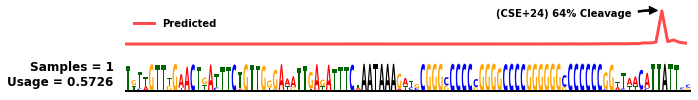

In [6]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Vanilla')

pwms = vanilla_pwms
cuts = vanilla_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)


<h2>Run SeqProp to Maximize Cleavage (Punish A-runs objective)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Auxiliary objectives: Punish upstream C, reward packing Gs and Cs in stretches, Punish stretches of A.<br/>


Running optimization experiment 'Punish A-runs'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 69s 35ms/step - loss: 3.4562


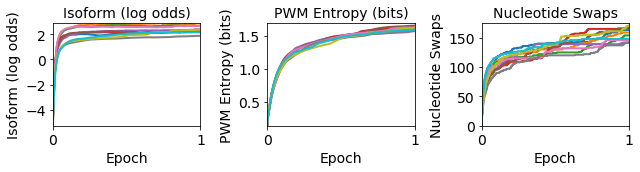

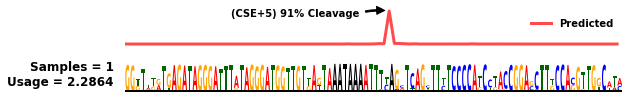

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 75s 38ms/step - loss: 1.6674


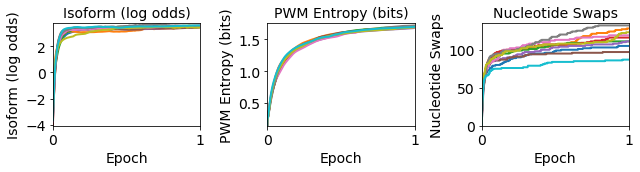

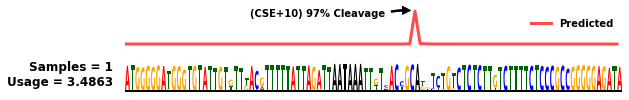

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 76s 38ms/step - loss: 1.1119


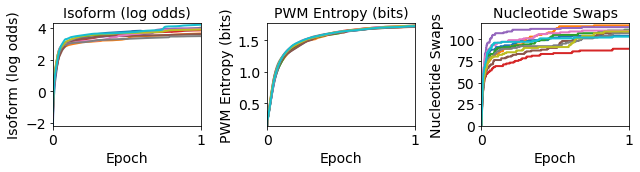

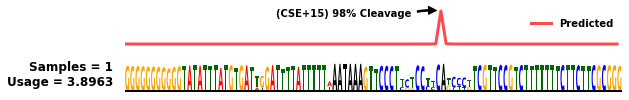

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 75s 38ms/step - loss: 1.2037


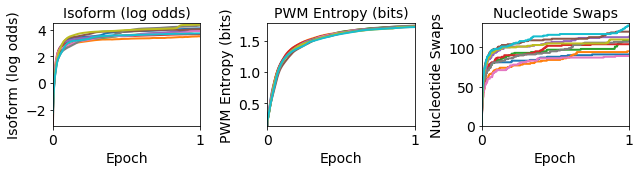

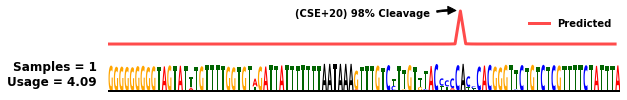

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 79s 40ms/step - loss: 1.3260


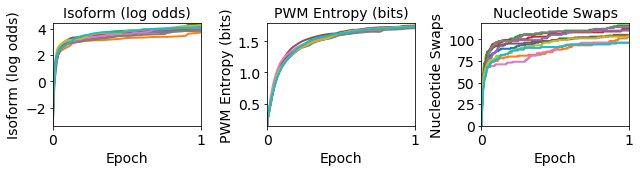

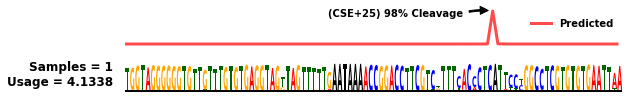

Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 79s 40ms/step - loss: -2.1982


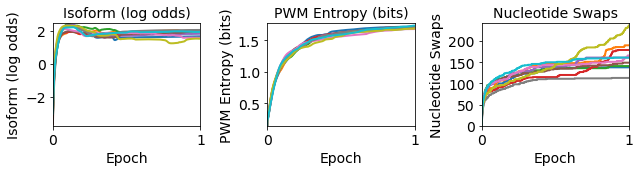

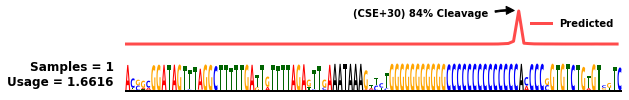

Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 2.3505


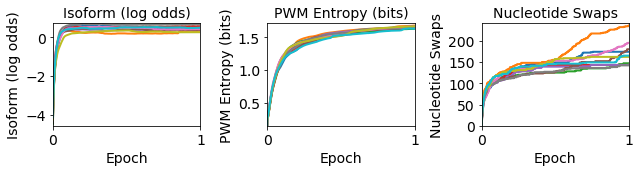

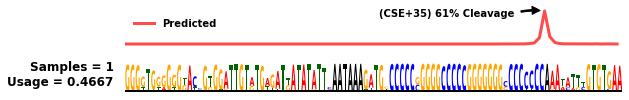

Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 80s 40ms/step - loss: 1.8977


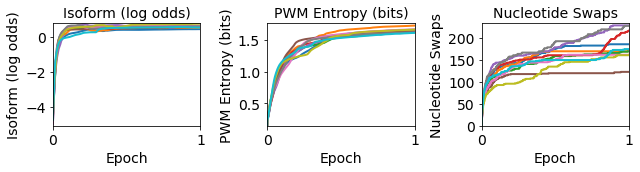

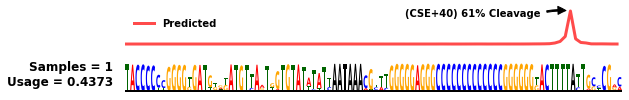

Optimizing objective 8...
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 1.3495


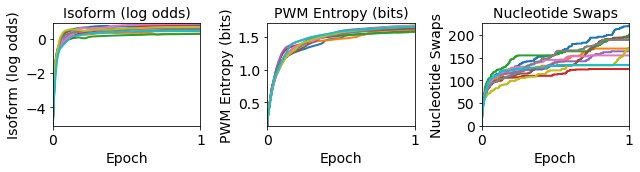

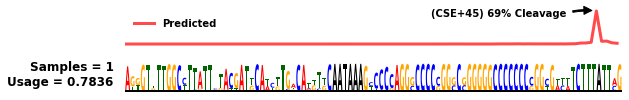

In [7]:
#Run SeqProp Optimization (experiment 'Punish A-runs')

print("Running optimization experiment 'Punish A-runs'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.005,
        reward_dn_ggcc=0.005 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.015,
        punish_dn_aa=0.05
    ) for cut_pos in cut_objectives
]

punish_aruns_pwms, punish_aruns_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


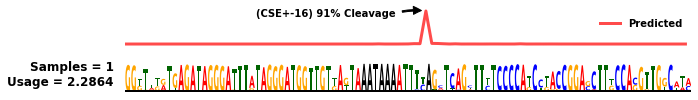

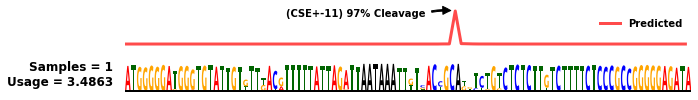

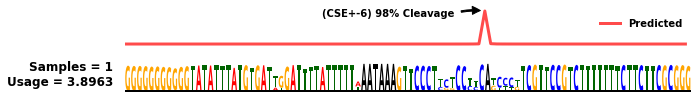

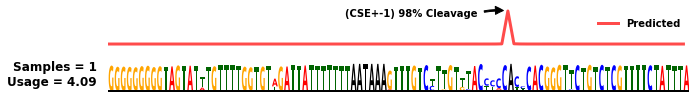

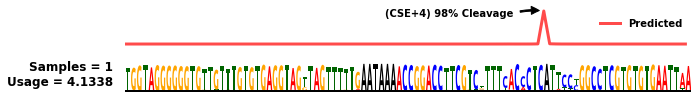

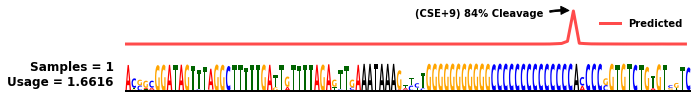

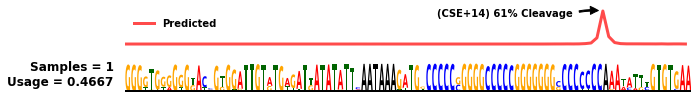

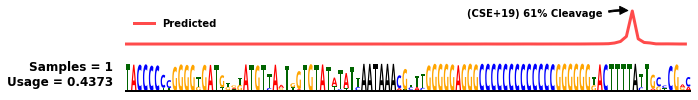

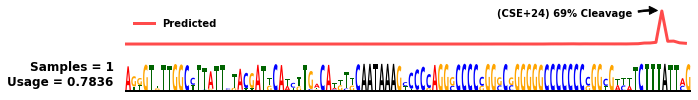

In [8]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

pwms = punish_aruns_pwms
cuts = punish_aruns_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)


<h2>Run SeqProp to Maximize Cleavage (Hardcoded AT objective)</h2>

- Generate 10 PWMs per target cut position.<br/>
- Auxiliary objectives: Punish upstream C, reward packing Gs and Cs in stretches.<br/>
- Hard-code an AT dinucleotide at the target cut position, restricting poly-A buildup.<br/>


Running optimization experiment 'Hardcoded AT'
Optimizing objective 0...
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 3.2633


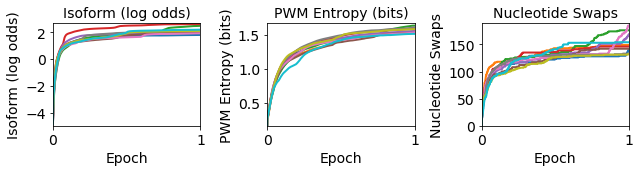

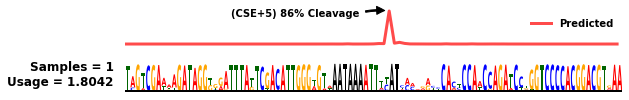

Optimizing objective 1...
Epoch 1/1
2000/2000 [==============================] - 91s 45ms/step - loss: 1.7265


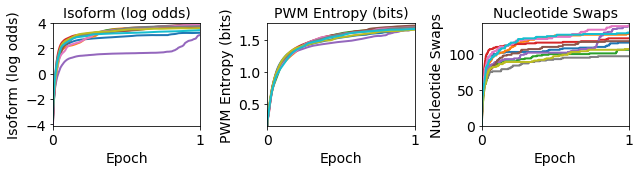

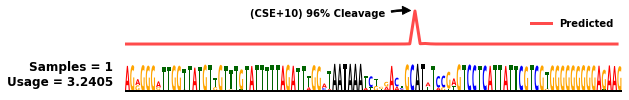

Optimizing objective 2...
Epoch 1/1
2000/2000 [==============================] - 78s 39ms/step - loss: 0.9033


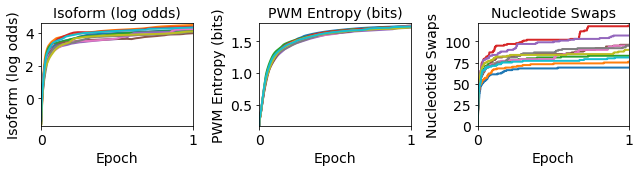

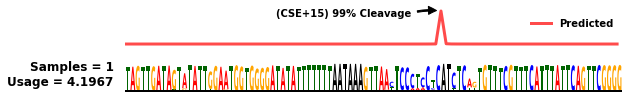

Optimizing objective 3...
Epoch 1/1
2000/2000 [==============================] - 79s 40ms/step - loss: 0.9936


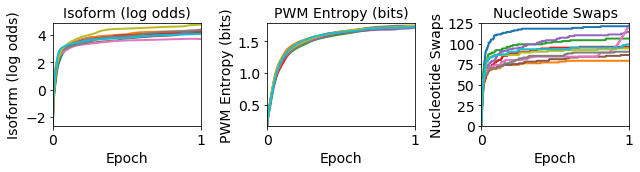

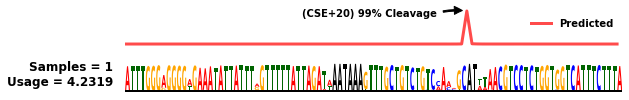

Optimizing objective 4...
Epoch 1/1
2000/2000 [==============================] - 81s 41ms/step - loss: 1.1560


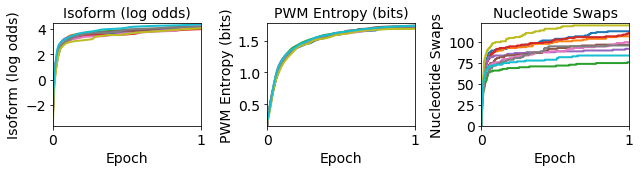

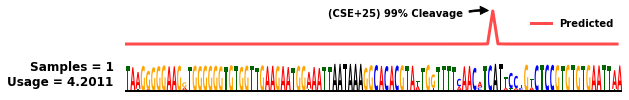

Optimizing objective 5...
Epoch 1/1
2000/2000 [==============================] - 77s 39ms/step - loss: -1.8081


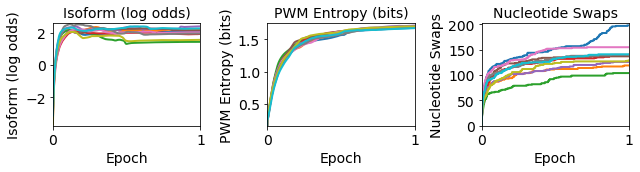

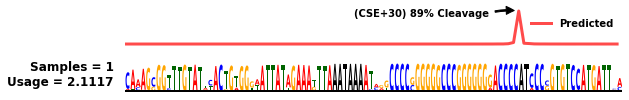

Optimizing objective 6...
Epoch 1/1
2000/2000 [==============================] - 76s 38ms/step - loss: 1.0739


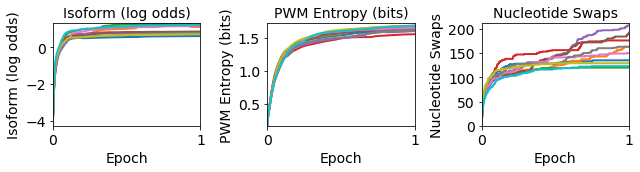

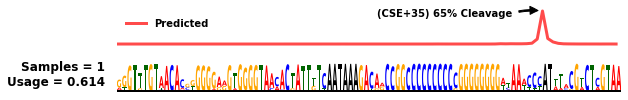

Optimizing objective 7...
Epoch 1/1
2000/2000 [==============================] - 80s 40ms/step - loss: 1.7995


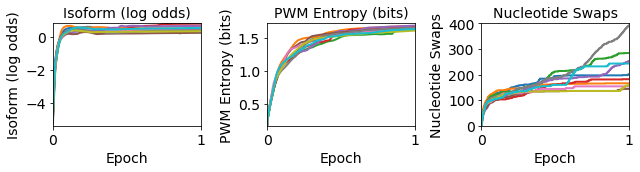

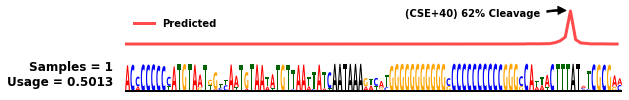

Optimizing objective 8...
Epoch 1/1
2000/2000 [==============================] - 84s 42ms/step - loss: 1.4465


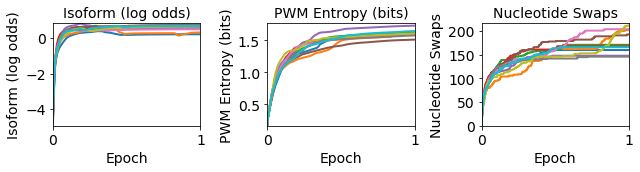

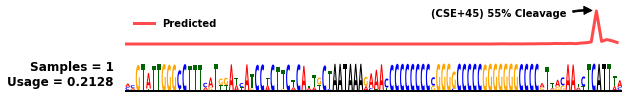

In [9]:
#Run SeqProp Optimization (experiment 'Hardcoded AT')

print("Running optimization experiment 'Hardcoded AT'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 1#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 2000

sequence_templates = [
    seq_template[:cut_pos] + "AT" + seq_template[cut_pos + 2:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        use_start=4,
        use_end=49,
        use_target_bits=1.8,
        cse_start=49,
        cse_end=55,
        cse_target_bits=1.9,
        dse_start=55,
        dse_end=105,
        dse_target_bits=1.8,
        entropy_weight=0.1,
        punish_up_c=0.005,
        reward_dn_ggcc=0.005 if cut_pos >= 85 else 0.0,
        punish_up_aa=0.001,
        punish_dn_aa=0.0
    ) for cut_pos in cut_objectives
]

hardcoded_at_pwms, hardcoded_at_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


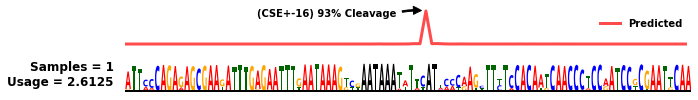

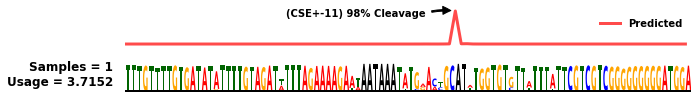

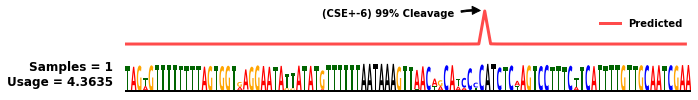

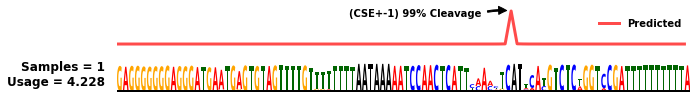

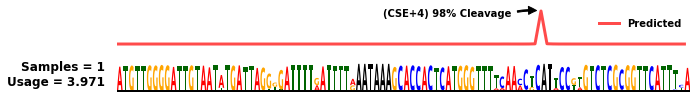

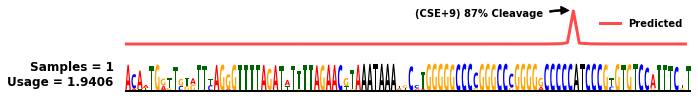

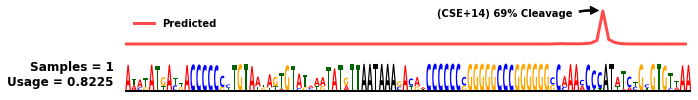

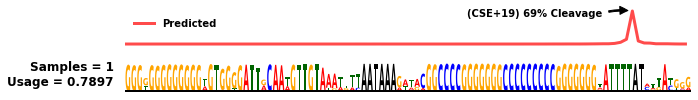

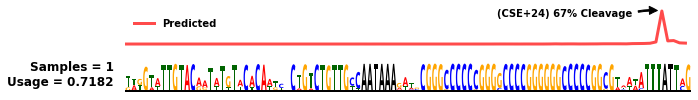

In [12]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Hardcoded AT')

pwms = hardcoded_at_pwms
cuts = hardcoded_at_cuts

pwm_index = 1 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=49-40, plot_end=55+50)
